# 前半

In [3]:
# データのロード
import pandas as pd
import re
import numpy as np

# ファイル読み込み
file = '/work/NLP-100-exercise-2020/CH6 Machine-learning/newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
# 単語の辞書を作成
from collections import Counter
words = []
for text in train['TITLE']:
    for word in text.rstrip().split():
        words.append(word)
c = Counter(words)
word2id = {}
for i, cnt in enumerate(c.most_common()):
    if cnt[1] > 1:
        word2id[cnt[0]] = i + 1
for i, cnt in enumerate(word2id.items()):
    if i >= 10:
        break
    print(cnt[0], cnt[1])

to 1
0 2
in 3
as 4
on 5
UPDATE 6
for 7
The 8
of 9
US 10


In [5]:
# 単語のID化
def tokenizer(text):
    words = text.rstrip().split()
    return [word2id.get(word, 0) for word in words]

sample = train.at[0, 'TITLE']
print(sample)
print(tokenizer(sample))

Justin Bieber Under Investigation For Attempted Robbery At Dave  Busters
[68, 76, 782, 1974, 21, 5054, 5055, 34, 1602, 0]


In [6]:
import torch
from torch import nn

VOCAB_SIZE = 4
EMB_SIZE = 3
emb = nn.Embedding(VOCAB_SIZE, EMB_SIZE)

words = torch.tensor([1, 3, 0, 2, 1, 2])
embed_words = emb(words)
print(embed_words)
print(words.shape, '->', embed_words.shape)

tensor([[-2.2300, -0.5251,  0.2641],
        [ 0.7557,  0.5751, -0.9983],
        [-2.3014,  0.2651, -1.2018],
        [-0.8029,  0.8085,  0.3330],
        [-2.2300, -0.5251,  0.2641],
        [-0.8029,  0.8085,  0.3330]], grad_fn=<EmbeddingBackward0>)
torch.Size([6]) -> torch.Size([6, 3])


In [7]:
# RNNの作成
# モデルの構築
import random
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary

# 乱数のシードを設定
# parserなどで指定
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h0=None):
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2  # 辞書のID数 + unknown + パディングID
EMB_SIZE = 300 # dw
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50 # dh
NUM_LAYERS = 1

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
print(model)

RNN(
  (emb): Embedding(9725, 300, padding_idx=9724)
  (rnn): LSTM(300, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)


In [8]:
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)
print(x)
print(x.size())
print(nn.Softmax(dim=-1)(model(x)))

tensor([[  68,   76,  782, 1974,   21, 5054, 5055,   34, 1602,    0]])
torch.Size([1, 10])
tensor([[0.2783, 0.2129, 0.2804, 0.2284]], grad_fn=<SoftmaxBackward0>)


In [9]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
print(Y_train.size())
print(Y_train)

torch.Size([10672])
tensor([2, 0, 2,  ..., 0, 0, 0])


In [10]:
class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス
    
    Attributes
    ----------------------------
    X : データフレーム
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X['TITLE']
        self.y = y
        self.phase = phase
    
    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)
    
    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        inputs = torch.tensor(tokenizer(self.X[idx]))
        return inputs, self.y[idx]

train_dataset = NewsDataset(train, Y_train, phase='train')
valid_dataset = NewsDataset(valid, Y_valid, phase='val')
test_dataset = NewsDataset(test, Y_test, phase='val')
# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])

torch.Size([10])
tensor(2)
torch.Size([11])
tensor(3)
torch.Size([13])
tensor(2)


In [11]:
# DataLoaderを作成
batch_size = 1

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)


torch.Size([1, 11])
tensor([2])


In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 5
--------------------------------------------


100%|██████████| 10672/10672 [03:00<00:00, 59.23it/s]


train Loss: 0.9959, Acc: 0.6041


100%|██████████| 1334/1334 [00:09<00:00, 148.15it/s]


val Loss: 0.7686, Acc: 0.7391
Epoch 2 / 5
--------------------------------------------


100%|██████████| 10672/10672 [03:01<00:00, 58.83it/s]


train Loss: 0.6238, Acc: 0.7738


100%|██████████| 1334/1334 [00:07<00:00, 182.03it/s]


val Loss: 0.6187, Acc: 0.7676
Epoch 3 / 5
--------------------------------------------


100%|██████████| 10672/10672 [02:58<00:00, 59.66it/s]


train Loss: 0.3916, Acc: 0.8594


100%|██████████| 1334/1334 [00:08<00:00, 151.38it/s]


val Loss: 0.5862, Acc: 0.7864
Epoch 4 / 5
--------------------------------------------


100%|██████████| 10672/10672 [03:00<00:00, 59.05it/s]


train Loss: 0.2254, Acc: 0.9228


100%|██████████| 1334/1334 [00:08<00:00, 157.34it/s]


val Loss: 0.5867, Acc: 0.8058
Epoch 5 / 5
--------------------------------------------


100%|██████████| 10672/10672 [03:02<00:00, 58.48it/s]


train Loss: 0.1297, Acc: 0.9602


100%|██████████| 1334/1334 [00:08<00:00, 166.67it/s]

val Loss: 0.6066, Acc: 0.8103


In [13]:
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.LongTensor([x[1] for x in batch])
    x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    return x, labels

# DataLoaderを作成
batch_size = 64

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs)
print(labels)

tensor([[   2, 7615,   21,  ..., 9724, 9724, 9724],
        [5245, 3031,   21,  ..., 9724, 9724, 9724],
        [1058,  309,    2,  ..., 9724, 9724, 9724],
        ...,
        [1163, 1278,  431,  ..., 9724, 9724, 9724],
        [1244, 1994, 1244,  ..., 9724, 9724, 9724],
        [   0,   61,    0,  ..., 9724, 9724, 9724]])
tensor([2, 2, 1, 1, 2, 2, 2, 2, 3, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 2,
        0, 0, 2, 0, 0, 2, 3, 2, 0, 0, 0, 2, 2, 3, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0,
        2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0])


In [14]:
# 学習を実行する
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name())
    print("使用デバイス:", device)
    
    # ネットワークをgpuへ
    net.to(device)
    
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    
    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード
            
            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化
                
                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想
                    
                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())
            
        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Tesla V100-SXM2-32GB
使用デバイス: cuda:0
Epoch 1 / 30 (train) Loss: 1.1923, Acc: 0.4266, (val) Loss: 1.1565, Acc: 0.4498
Epoch 2 / 30 (train) Loss: 1.1543, Acc: 0.4676, (val) Loss: 1.1458, Acc: 0.4888
Epoch 3 / 30 (train) Loss: 1.1445, Acc: 0.4938, (val) Loss: 1.1315, Acc: 0.5157
Epoch 4 / 30 (train) Loss: 1.1255, Acc: 0.5244, (val) Loss: 1.1009, Acc: 0.5390
Epoch 5 / 30 (train) Loss: 1.0576, Acc: 0.5844, (val) Loss: 0.9663, Acc: 0.6514
Epoch 6 / 30 (train) Loss: 0.9200, Acc: 0.6737, (val) Loss: 0.8686, Acc: 0.6957
Epoch 7 / 30 (train) Loss: 0.8037, Acc: 0.7299, (val) Loss: 0.8088, Acc: 0.7189
Epoch 8 / 30 (train) Loss: 0.7068, Acc: 0.7625, (val) Loss: 0.7588, Acc: 0.7436
Epoch 9 / 30 (train) Loss: 0.6414, Acc: 0.7794, (val) Loss: 0.7437, Acc: 0.7421
Epoch 10 / 30 (train) Loss: 0.5682, Acc: 0.7979, (val) Loss: 0.6945, Acc: 0.7594
Epoch 11 / 30 (train) Loss: 0.5085, Acc: 0.8138, (val) Loss: 0.7170, Acc: 0.7466
Epoch 12 / 30 (train) Loss: 0.4625, Acc: 0.8308, (val) Loss: 0.7116, Acc: 0.7436
E

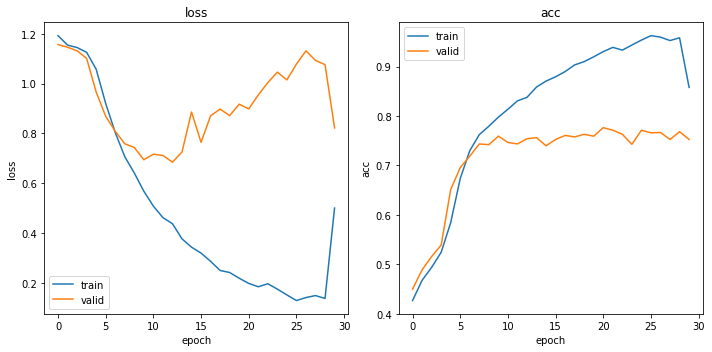

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig83.png')
plt.show()

In [16]:
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.8982
検証データの正解率: 0.7526
テストデータの正解率: 0.7721


In [17]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
file = '/work/NLP-100-exercise-2020/CH7 Word-embedding/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9042 / 9725
torch.Size([9725, 300])


Tesla V100-SXM2-32GB
使用デバイス: cuda:0


Epoch 1 / 50 (train) Loss: 1.1830, Acc: 0.4252, (val) Loss: 1.1618, Acc: 0.4333
Epoch 2 / 50 (train) Loss: 1.1605, Acc: 0.4420, (val) Loss: 1.1607, Acc: 0.4925
Epoch 3 / 50 (train) Loss: 1.1595, Acc: 0.4316, (val) Loss: 1.1585, Acc: 0.4558
Epoch 4 / 50 (train) Loss: 1.1572, Acc: 0.4667, (val) Loss: 1.1558, Acc: 0.4775
Epoch 5 / 50 (train) Loss: 1.1540, Acc: 0.4664, (val) Loss: 1.1523, Acc: 0.4685
Epoch 6 / 50 (train) Loss: 1.1488, Acc: 0.4945, (val) Loss: 1.1450, Acc: 0.4828
Epoch 7 / 50 (train) Loss: 1.1403, Acc: 0.5026, (val) Loss: 1.1342, Acc: 0.5180
Epoch 8 / 50 (train) Loss: 1.1304, Acc: 0.5082, (val) Loss: 1.1141, Acc: 0.5352
Epoch 9 / 50 (train) Loss: 1.0764, Acc: 0.5680, (val) Loss: 1.0195, Acc: 0.6124
Epoch 10 / 50 (train) Loss: 1.0123, Acc: 0.6154, (val) Loss: 0.9676, Acc: 0.6454
Epoch 11 / 50 (train) Loss: 0.9685, Acc: 0.6466, (val) Loss: 0.9991, Acc: 0.6169
Epoch 12 / 50 (train) Loss: 0.9380, Acc: 0.6613, (val) Loss: 0.9202, Acc: 0.6762
Epoch 13 / 50 (train) Loss: 0.9198, A

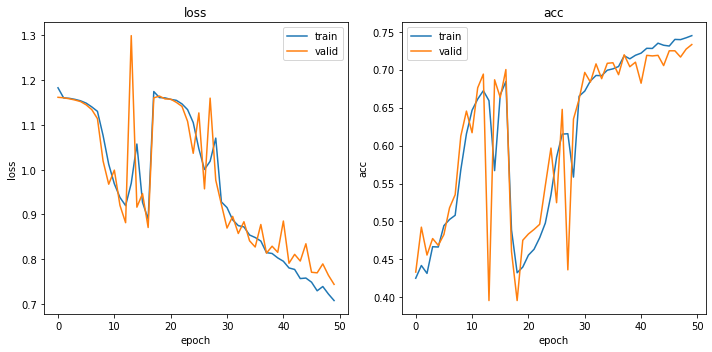

学習データの正解率: 0.7537
検証データの正解率: 0.7331
テストデータの正解率: 0.7436


In [18]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h0=None):
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2  # 辞書のID数 + unknown + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 50
train_loss_weights, train_acc_weights, valid_loss_weights, valid_acc_weights = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss_weights, label='train')
ax[0].plot(epochs, valid_loss_weights, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc_weights, label='train')
ax[1].plot(epochs, valid_acc_weights, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig84.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

In [19]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)
print(x)
print(x.size())
print(nn.Softmax(dim=-1)(model(x)))

tensor([[  68,   76,  782, 1974,   21, 5054, 5055,   34, 1602,    0]])
torch.Size([1, 10])
tensor([[0.2441, 0.2543, 0.2571, 0.2445]], grad_fn=<SoftmaxBackward0>)


Tesla V100-SXM2-32GB
使用デバイス: cuda:0
Epoch 1 / 30 (train) Loss: 0.9660, Acc: 0.6160, (val) Loss: 0.7333, Acc: 0.7324
Epoch 2 / 30 (train) Loss: 0.6714, Acc: 0.7545, (val) Loss: 0.6002, Acc: 0.7879
Epoch 3 / 30 (train) Loss: 0.5112, Acc: 0.8147, (val) Loss: 0.5584, Acc: 0.8066
Epoch 4 / 30 (train) Loss: 0.4066, Acc: 0.8546, (val) Loss: 0.5156, Acc: 0.8201
Epoch 5 / 30 (train) Loss: 0.3236, Acc: 0.8838, (val) Loss: 0.5000, Acc: 0.8253
Epoch 6 / 30 (train) Loss: 0.2697, Acc: 0.9017, (val) Loss: 0.5170, Acc: 0.8253
Epoch 7 / 30 (train) Loss: 0.2308, Acc: 0.9189, (val) Loss: 0.5226, Acc: 0.8283
Epoch 8 / 30 (train) Loss: 0.1975, Acc: 0.9305, (val) Loss: 0.5268, Acc: 0.8238
Epoch 9 / 30 (train) Loss: 0.1792, Acc: 0.9361, (val) Loss: 0.5498, Acc: 0.8253
Epoch 10 / 30 (train) Loss: 0.1560, Acc: 0.9437, (val) Loss: 0.5489, Acc: 0.8343
Epoch 11 / 30 (train) Loss: 0.1387, Acc: 0.9517, (val) Loss: 0.5924, Acc: 0.8366
Epoch 12 / 30 (train) Loss: 0.1278, Acc: 0.9550, (val) Loss: 0.5812, Acc: 0.8328
E

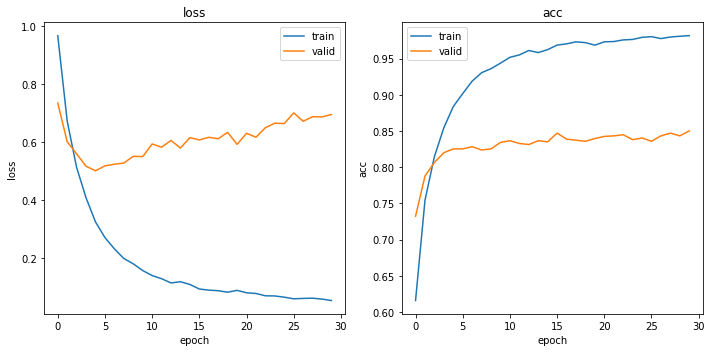

学習データの正解率: 0.9989
検証データの正解率: 0.8501
テストデータの正解率: 0.8688


In [20]:
# モデルの定義
net = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig87.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

Tesla V100-SXM2-32GB
使用デバイス: cuda:0
Epoch 1 / 30 (train) Loss: 1.0457, Acc: 0.5992, (val) Loss: 0.8952, Acc: 0.6732
Epoch 2 / 30 (train) Loss: 0.7881, Acc: 0.7225, (val) Loss: 0.7129, Acc: 0.7496
Epoch 3 / 30 (train) Loss: 0.6094, Acc: 0.7934, (val) Loss: 0.6178, Acc: 0.7961
Epoch 4 / 30 (train) Loss: 0.4842, Acc: 0.8396, (val) Loss: 0.5562, Acc: 0.8148
Epoch 5 / 30 (train) Loss: 0.3893, Acc: 0.8757, (val) Loss: 0.5144, Acc: 0.8216
Epoch 6 / 30 (train) Loss: 0.3150, Acc: 0.9070, (val) Loss: 0.4974, Acc: 0.8366
Epoch 7 / 30 (train) Loss: 0.2626, Acc: 0.9259, (val) Loss: 0.4703, Acc: 0.8433
Epoch 8 / 30 (train) Loss: 0.2117, Acc: 0.9449, (val) Loss: 0.4571, Acc: 0.8403
Epoch 9 / 30 (train) Loss: 0.1780, Acc: 0.9589, (val) Loss: 0.4446, Acc: 0.8501
Epoch 10 / 30 (train) Loss: 0.1464, Acc: 0.9680, (val) Loss: 0.4468, Acc: 0.8426
Epoch 11 / 30 (train) Loss: 0.1191, Acc: 0.9770, (val) Loss: 0.4370, Acc: 0.8523
Epoch 12 / 30 (train) Loss: 0.1029, Acc: 0.9804, (val) Loss: 0.4311, Acc: 0.8553
E

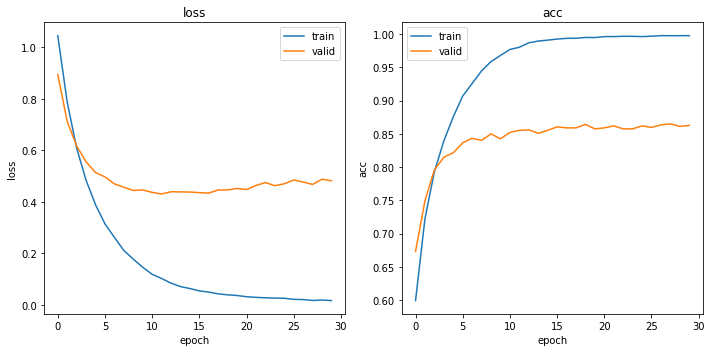

学習データの正解率: 0.9992
検証データの正解率: 0.8628
テストデータの正解率: 0.8793


In [21]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 500
KERNEL_HEIGHTS = 2
STRIDE = 1
PADDING = 1

# モデルの定義
net = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig88.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))